In [1]:
# Given Imports
import torch
import re
import statistics
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer
from datasets import load_dataset, Dataset

C:\tools\Manim\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
torch.cuda.empty_cache()

### Load Encoders and Tokenizers

In [4]:
# Protein encoder
prot_tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
prot_model = BertModel.from_pretrained("Rostlab/prot_bert").to(device)

# Molecule encoder
mol_tokenizer = RobertaTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
mol_model = RobertaModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1").to(device)

# max_prot_input_size = prot_model.config.max_position_embeddings
max_prot_input_size = 3000 #capped at 3000 since tokens longer than 3000 use way too much vram
max_mol_input_size = mol_model.config.max_position_embeddings-2

c:\Python311\Lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\shen_\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


### Load Dataset

In [25]:
dataset = load_dataset("jglaser/binding_affinity")['train']

In [26]:
mole = dataset['smiles']
print(mole[:10])

['CCCCCCCCCCCCCCCCCCCC(=O)O', 'OC[C@H]1O[C@H](Oc2cccc(c2)N(=O)=O)[C@@H]([C@H]([C@H]1O)O)O', 'COc1ccc(cc1)c1c(onc1c1cc(C(C)C)c(cc1O)O)NC(=O)C1=CC1', 'OC[C@@H](C(=O)N[C@@H]([C@H](CC)C)C(=O)O)NC(=O)[C@H](CC1=CN=C2[C@@H]1C=CC=C2)NC(=O)[C@H](CC(=O)O)[NH3+]', 'CO[C@@H]1[C@H](O[C@H]([C@@H]1O)n1ccc(=O)[nH]c1=O)[C@H](C(=O)N)O[C@H]1OC(=C[C@@H]([C@@H]1O)O)C(=O)N[C@H]1CCCCNC1=O', 'OC(=O)[C@@H](NC1=NC(C)(C)Cc2c1cccc2)Cc1ccccc1', 'Cc1ccc(cc1c1ccc2c(c1)[nH]c(=O)n2C)NC(=O)c1cccc(c1)C(F)(F)F', 'O[C@H]1O[C@H](COP(=O)(O)O)[C@H]([C@H]([C@H]1O)O)O', 'CC[C@@H]([C@@H](C(=O)N[C@H](C(=O)NCC(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)N[C@H](C(=O)N[C@H](C(=O)O)CC(=O)N)[C@H](CC)C)Cc1ccc(cc1)O)[C@H](O)C)[C@H](O)C)C(C)C)NC(=O)[C@@H](NC(=O)[C@H](Cc1ccccc1)[NH3+])CC(=O)N)C', 'OCC[C@@H]1CCCCN1c1cc(NCC2=CC=CN(C2)O)n2c(n1)c(CC)cn2']


In [6]:
dataset.to_csv(r'Data\pre_encoding\data.csv')

Creating CSV from Arrow format:   0%|          | 0/1837 [00:00<?, ?ba/s]

Creating CSV from Arrow format: 100%|██████████| 1837/1837 [00:53<00:00, 34.26ba/s]


1440453142

### Preprocess & Tokenize Data

Replace irregular amino acids in the dataset's protein sequences with "X", which is necessary for accurate tokenization and encodings from the ProtBERT model
Parallelized map function is used

In [7]:
def preprocess_function(example):
    import re
    example['seq'] = " ".join(re.sub(r"[UZOB]", "X", example['seq']))
    return example

dataset = dataset.map(preprocess_function, num_proc=8)

In [8]:
def tokenize_prot(example):
    from transformers import BertTokenizer
    prot_tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
    return prot_tokenizer(example['seq'], padding=True, truncation=True, max_length=40000, return_tensors='pt')

def tokenize_mol(example):
    from transformers import RobertaTokenizer
    mol_tokenizer = RobertaTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
    return mol_tokenizer(example['smiles_can'], padding=True, truncation=True, max_length=max_mol_input_size, return_tensors='pt')

In [9]:
dataset=Dataset.from_dict({"seq":dataset["seq"]})

In [38]:
prot_tokens = dataset.map(tokenize_prot,batched=True,num_proc=8)

Map (num_proc=8):   0%|          | 0/1836729 [00:00<?, ? examples/s]

MemoryError: 

In [ ]:
prot_tokens.remove_columns("seq")

In [ ]:
mol_dataset=Dataset.from_dict({"smiles_can":dataset["smiles_can"]})

In [33]:
prot_tokens = prot_dataset.map(tokenize_prot,batched=True,num_proc=8).remove_columns("seq")
mol_tokens = mol_dataset.map(tokenize_mol,batched=True,num_proc=8).remove_columns("smiles_can")

Map (num_proc=8):   0%|          | 0/1836729 [00:00<?, ? examples/s]

MemoryError: 

In [16]:
prot_tokens

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 18367
})

In [15]:
mol_tokens

Dataset({
    features: ['seq', 'smiles', 'affinity_uM', 'neg_log10_affinity_M', 'smiles_can', 'affinity'],
    num_rows: 18367
})

In [22]:
def func(example):
    return {"len":sum(example["attention_mask"])}

In [23]:
lengths = prot_tokens.map(func,num_proc=8)

Map (num_proc=8):   0%|          | 0/18367 [00:00<?, ? examples/s]

In [24]:
l=lengths['len']

In [26]:
print(statistics.stdev(l))
print(statistics.mean(l))

485.165820474725
632.4904448195133


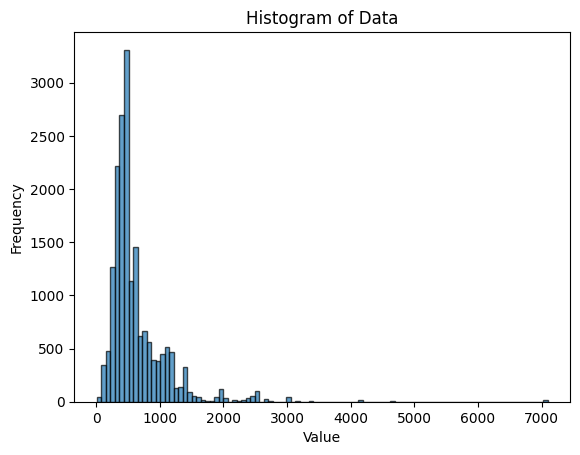

In [28]:
import matplotlib.pyplot as plt

# Create the histogram
plt.hist(l, bins=100, edgecolor='black', alpha=0.7)

# Add title and labels to the plot
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the histogram
plt.show()


### Encoding and Tokenizing Functions

In [11]:
# Define Encoding functions
def encode_batch(batch, tokenizer, model, max_input_size):
    tokens = tokenizer(batch, padding=True, truncation=True, max_length=max_input_size, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**tokens.to(device)).pooler_output
    # representations = outputs.last_hidden_state.mean(dim=1)
    return outputs.cpu()

def encode_sequences(prot_seq, mol_smiles, mol_batch_size=16, prot_batch_size=2):
    # Encode in batches to prevent out-of-memory errors
    prot_representations = []
    mol_representations = []
    
    mol_loader = DataLoader(mol_smiles, batch_size=mol_batch_size, shuffle=False)
    for i, mol_batch in enumerate(mol_loader, 1):
        if i % 20 == 0:
            print(f"\rEncoding molecule batch {i}/{len(mol_loader)}...", end="")
        mol_representations.append(encode_batch(mol_batch, mol_tokenizer, mol_model, max_mol_input_size))
    print("done!")
    
    mol_model.to("cpu")
    torch.cuda.empty_cache()
    
    prot_loader = DataLoader(prot_seq, batch_size=prot_batch_size, shuffle=False)
    for i, prot_batch in enumerate(prot_loader, 1):
        print(f"\rEncoding protein batch {i}/{len(prot_loader)}...", end="")
        prot_representations.append(encode_batch(prot_batch, prot_tokenizer, prot_model, max_prot_input_size))
        torch.cuda.empty_cache()
    print("done!")
    return torch.cat(prot_representations, dim=0), torch.cat(mol_representations, dim=0)

In [12]:
def create_tensor_dataset(dataset):
    proteins, smiles, affinities = dataset["seq"], dataset["smiles_can"], dataset["affinity"]
    prot_rep, chem_rep = encode_sequences(proteins, smiles)
    return TensorDataset(prot_rep, chem_rep, torch.tensor(affinities))

In [13]:
print("encoding data...")
tensor_dataset = create_tensor_dataset(dataset)

encoding data...
Encoding molecule batch 100/115...done!
Encoding protein batch 84/918...

KeyboardInterrupt: 

In [ ]:
len(tensor_dataset)

1836

In [ ]:
torch.save(tensor_dataset, r"C:\Users\tatwo\Downloads\encoded_data_final")

In [ ]:
tokens=mol_tokenizer(["CCCCCCCCCCCCCCCCCCCC(=O)O"], padding=True, truncation=True, max_length=512, return_tensors='pt')
mol_model(**tokens)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.4373, -0.6694, -1.0074,  ..., -0.9850,  0.2792,  1.4708],
         [-0.1302, -1.5081, -0.6598,  ...,  0.2113,  1.4561,  0.2045],
         [ 0.8827, -0.3146, -1.0314,  ...,  1.0429,  1.5200,  0.1877],
         ...,
         [-0.3223, -1.1277,  0.2969,  ..., -1.9156,  0.3809,  1.1264],
         [ 0.0172,  1.5409, -0.9348,  ..., -0.8201,  0.8186, -0.6957],
         [-1.4186, -1.0689,  0.3970,  ..., -0.7573,  0.7821,  0.7213]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 2.9266e-01, -2.0106e-01, -2.5144e-01,  2.7638e-01, -5.9401e-01,
          4.7673e-01,  4.0142e-01,  1.5805e-01, -2.2580e-01, -4.7935e-01,
         -6.7652e-01,  1.6724e-02,  9.4531e-01,  3.6973e-01,  3.7976e-01,
         -2.0460e-01, -1.0615e-01, -3.7676e-01, -1.8930e-01, -2.3977e-01,
          8.3878e-03,  2.7116e-01, -2.4827e-01,  2.4240e-01, -6.5158e-01,
         -1.0794e-01, -2.9413e-01, -1.7536e-01,  4.4841e-02, -9.339